## Requirements

* Detect predetorial patterns in other side chat messages, alert parents / block chat
    - Per message
    - Sequence
    - Media
* Detect and warn / block personal information giveaway by own side of chat (Child)
    - text
    - media
* Support 2 party / multiple party chats
* Block known predators from past chats




## Flow control

In [1]:
'''
Options:
Each element can be either 'Process' or 'Load'
'''

CREATE_FULL_PJ_DATAFRAME = 'Load'
CREATE_FULL_PAN12_DATAFRAME = 'Load'
PREPROCESS_FULL_PAN12_DATAFRAME = 'Load'
PAN12_TOPIC_MODEL = 'Load'
PAN12_TOPIC_MODEL_RF = 'Load'



## General - imports paths etc.

In [2]:
%pip install pyspellchecker
!python -m spacy download en_core_web_sm
%pip install pyLDAvis
%pip install altair


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 15.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import random
import re
import string

from tqdm.notebook import tqdm as tqdm
tqdm.pandas()
from ipywidgets import IntProgress

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer

# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import altair

# from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from torch.utils.data import Dataset

import gensim
from gensim.models import Word2Vec
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import spacy
from spellchecker import SpellChecker

import xml.etree.ElementTree as ET 
from xml.etree.ElementTree import ParseError

import csv

from typing import Dict, Callable, List, Dict, Set, Any
import logging


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logger = logging.getLogger(__name__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


### Env control and folders

In [4]:
ENV = 'Colab'
# ENV = 'Local'


In [5]:
# Folders
if ENV=='Local':
  PROJECT_ROOT = Path('./')

elif ENV=='Colab':
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = Path('/content/drive/MyDrive/colab_data/cyber2/')
  

PJ_DATA_FOLDER = PROJECT_ROOT / Path('customer_data')
PAN12_TEST_DATA_FILE = PROJECT_ROOT / Path('ref_data/pan12_corpus/pan12-sexual-predator-identification-test-corpus-2012-05-21/pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
PAN12_LINE_LABELS_FILE = PROJECT_ROOT / Path('ref_data/pan12_corpus/pan12-sexual-predator-identification-test-corpus-2012-05-21/pan12-sexual-predator-identification-groundtruth-problem2.txt')
PAN12_USER_LABELS_FILE = PROJECT_ROOT / Path('ref_data/pan12_corpus/pan12-sexual-predator-identification-test-corpus-2012-05-21/pan12-sexual-predator-identification-groundtruth-problem1.txt')

PAN12_TRAIN_DATA_FILE = PROJECT_ROOT / Path('ref_data/pan12_corpus/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-2012-05-01.xml')
PAN12_TRAIN_USER_LABELS_FILE = PROJECT_ROOT / Path('ref_data/pan12_corpus/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt')


OUTPUT_FOLDER = PROJECT_ROOT / Path('output')

if not PAN12_TEST_DATA_FILE.exists():
    raise FileNotFoundError('File not found!')

if not PAN12_LINE_LABELS_FILE.exists():
    raise FileNotFoundError('File not found!')  

if not PAN12_USER_LABELS_FILE.exists():
    raise FileNotFoundError('File not found!') 

if not PJ_DATA_FOLDER.is_dir():
    raise FileNotFoundError('Directry not found!') 

if not OUTPUT_FOLDER.is_dir():
    print(f'creating output folder: {OUTPUT_FOLDER}')
    OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Utility functions

In [6]:
# Define datasets with texts and labels

def list_files_in_dir(folder: Path, extension='*') -> List:
    
    file_list = [f for f in folder.glob(f'**/*.{extension}') if f.is_file()]
    return file_list


In [7]:
def unify_csv_dataframes_to_one_sorted(csv_parts_folder: Path, target_csv_path=None)-> pd.DataFrame:
    '''
    Gets:
        csv_parts_folder - Path of folder with partial df CSV files
        target_csv_path - (optional) - path to save unified CSV

    Returns:
        Unified PD dataframe with all csvs concatenated on axis 0
    '''

    file_list = list_files_in_dir(csv_parts_folder, extension='csv')
    ordered_filenames = sorted([str(filename) for filename in file_list])
    ordered_file_list = [Path(filename) for filename in ordered_filenames]
    print(f'Found {len(ordered_file_list)} files to unify')

    unified_df = None
    for file in ordered_file_list:
        part_df = pd.read_csv(file, header=0, index_col=0)

        if unified_df is not None:
            unified_df = pd.concat([unified_df, part_df], axis=0)
        else:
            unified_df = part_df

    if target_csv_path is not None:
        unified_df.to_csv(target_csv_path)
    
    return unified_df

### Load word lists

In [8]:
# Load word lists
SEX_WL_PATH = PROJECT_ROOT / Path(r'sex_words.txt')
with open(SEX_WL_PATH, 'rt') as handle:
    sex_word_list = handle.read().split('\n')

MEETING_WL_PATH = SEX_WL_PATH = PROJECT_ROOT / Path(r'meeting_words.txt')
with open(MEETING_WL_PATH, 'rt') as handle:
    meeting_word_list = handle.read().split('\n')

FAMILY_WL_PATH = SEX_WL_PATH = PROJECT_ROOT / Path(r'family_words.txt')
with open(FAMILY_WL_PATH, 'rt') as handle:
    family_word_list = handle.read().split('\n')

CHAT_SLANG_PATH = SEX_WL_PATH = PROJECT_ROOT / Path(r'chat_slang.txt')
with open(CHAT_SLANG_PATH, mode='rt') as handle:
    csv_reader = csv.reader(handle, delimiter='\t')
    chat_slang = {rows[0]:rows[1] for rows in csv_reader}

EMOTICONS_PATH = SEX_WL_PATH = PROJECT_ROOT / Path(r'emoticons.txt')
with open(EMOTICONS_PATH, mode='rt', encoding="utf8") as handle:
    csv_reader = csv.reader(handle, delimiter='\t')
    emoticons = {rows[0]:rows[1] for rows in csv_reader}


## Preprocessing

### Chat text preprocess

In [9]:

def remove_stopwords(text: str, words_to_remove: List[str])-> str:
    '''
    Gets string, returns it without stopwords
    '''
    return " ".join([word for word in str(text).split() if word not in words_to_remove])


def stem_text(text: str, stemmer: Any)-> str:
    '''
    stem text string
    '''
    return " ".join([stemmer.stem(word) for word in text.split()])


def remove_emoji(text: str) -> str:
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_emoticons(text: str, emoticons: Dict) -> str:
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in emoticons) + u')')
    return emoticon_pattern.sub(r'', text)


def replace_pornsites_with_string(text:str, replacement_string:str='porn')->str:
    pornsite_pattern = re.compile(r'\S+xnxx\.co\S+' + r'|\S+pornhub\.co\S+' + r'|\S+nude\.co\S+' + r'|\S+sex\.co\S+')
    return pornsite_pattern.sub(replacement_string, text)

def remove_urls(text:str)-> str:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


def remove_special_characters(text:str)-> str:
    special_chars_pattern = re.compile(r'[^A-Za-z0-9 ]+')
    return special_chars_pattern.sub(r' ', text)


def replace_chat_slang(text: str, chat_slang: Dict[str, str])-> str:
    new_text = []
    for w in text.split():
        if w.upper() in chat_slang.keys():
            new_text.append(chat_slang[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)


def correct_spellings(text: str, speller: Callable) -> str:
    corrected_text = []
    misspelled_words = speller.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(speller.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)


def lemmation(text:str, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp_lem = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    result = nlp_lem(text)
    result = [token.lemma_ for token in result if token.pos_ in allowed_postags]
    return  " ".join(result)


def contains_words_from_list(text: str, word_list: List[str])-> bool:
    text_words = re.sub("[^\w]", " ",  text).split()
    if any(word in word_list for word in text_words):
        return True
    else:
        return False


def preprocess_string_for_bow(text: str, stemmer: Callable=None, speller: Callable=None, words_to_remove:List[str]=None, emoticons: Dict[str, str]=None, chat_slang: Dict[str, str]=None)-> str:
    try:
        # text = remove_emoji(text)
        # text = remove_emoticons(text, emoticons)
        text = text.lower()
        text = replace_chat_slang(text, chat_slang)
        text = replace_pornsites_with_string(text)
        # text = remove_urls(text)
        text = remove_special_characters(text)
        text = correct_spellings(text, speller)
        text = lemmation(text)
        # text = remove_stopwords(text, words_to_remove)
        # text = stem_text(text, stemmer)
    except(TypeError):
        print(f'Problematic string: {text}')
        text = ''
    return text


def preprocess_df_for_bow(df: pd.DataFrame, text_col: str, output_col_name='preprocessed_bow', stemmer=None, speller=None, words_to_remove=None, emoticons=None, chat_slang=None)-> pd.DataFrame:
    '''
    Gets a PD dataframe and a text column name
    returns the same dataframe with additional column called 'posts_preprocessed_bow'
    '''
    df[output_col_name] = df[text_col].progress_apply(lambda text: preprocess_string_for_bow(text, stemmer=stemmer, speller=speller, words_to_remove=words_to_remove, emoticons=emoticons, chat_slang=chat_slang))
    return df


<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<input>:76: DeprecationWarning: invalid escape sequence \w
<ipython-input-9-b7f45eb76567>:76: DeprecationWarning: invalid escape sequence \w
  text_words = re.sub("[^\w]", " ",  text).split()


In [10]:
# test
preprocess_args = {'stemmer': PorterStemmer(),
                    'speller': SpellChecker(),
                    'words_to_remove': set(stopwords.words('english')),
                    'emoticons': emoticons,
                    'chat_slang': chat_slang,
                    }

text = 'r u going to www.google.com http://xnxx.com im walking LOL ths is not &amp;right im caming flight now u r right brb and fu :-)'
# text = 'yeah--well I just want to see you before I go in the apt--cause one of my friends :) lol :X) got arrested for doing the same thing with a 16 year old--it was a set-up type thing'

preprocess_string_for_bow(text, **preprocess_args)

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

'go com porn walk laugh loud amp right come flight now right right back'

## Feature engineering

### Word-list based features

In [11]:
def contains_words_from_list(text: str, word_list: List[str])-> bool:
    text_words = re.sub("[^\w]", " ",  text).split()
    if any(word in word_list for word in text_words):
        return True
    else:
        return False


def add_wordlist_features(df: pd.DataFrame, text_column: str, sex_word_list, family_word_list, meeting_word_list):
    df['contains_sex_words'] = df[text_column].apply(lambda text: contains_words_from_list(text, sex_word_list))
    df['contains_family_words'] = df[text_column].apply(lambda text: contains_words_from_list(text, family_word_list))
    df['contains_meeting_words'] = df[text_column].apply(lambda text: contains_words_from_list(text, meeting_word_list))
    return df


<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-11-f2838da8f5fa>:2: DeprecationWarning: invalid escape sequence \w
  text_words = re.sub("[^\w]", " ",  text).split()


## Datasets

### PJ dataset

#### PJ Convesation level dataset

In [12]:

def load_one_chat_as_df_pj(file_path: Path) -> Dict[str, pd.DataFrame]:
    '''
    Gets an path to a PJ XML file
    returns a dict with three dataframes:
        - victim data
        - predator data
        - conversation posts
    '''
    parser = ET.XMLParser(encoding="utf-8")
    try:
        doc_tree = ET.parse(file_path, parser=parser)
    except(ParseError):
        print(f'failed to parse {str(file_path)}')
        return None
        
    doc_root = doc_tree.getroot()
    
    posts_df = pd.DataFrame(columns = ['USERNAME', 'DATETIME', 'BODY', 'COMMENT', 'CODING'], dtype=str)
    predator_df = pd.DataFrame(columns = ['FIRSTNAME', 'LASTNAME', 'STATEDNAME', 'STATEDAGE', 'GENDER', 'RACE', 'CITY', 'STATE', 'REPEATOFFENDER', 'ADMITGUILT', 'TRUTHFULNAME', 'SCREENNAME'], dtype=str)
    victim_df = pd.DataFrame(columns = ['FIRSTNAME', 'LASTNAME', 'STATEDNAME', 'STATEDAGE', 'GENDER', 'RACE', 'CITY', 'STATE', 'PREVIOUSVICTIMIZATION', 'ADMITGUILT', 'SCREENNAME'], dtype=str)

    for post in doc_root.findall('POST'):
        post_dict = {}
        for field in post:
            post_dict[field.tag] = field.text

        posts_df = posts_df.append(post_dict, ignore_index=True)
    posts_df = posts_df.astype('string')


    for predator in doc_root.findall('PREDATOR'):
        predator_dict = {}
        for field in predator:
            predator_dict[field.tag] = field.text

        predator_df = predator_df.append(predator_dict, ignore_index=True)   
    predator_df = predator_df.astype('string')

    for victim in doc_root.findall('VICTIM'):
        victim_dict = {}
        for field in victim:
            victim_dict[field.tag] = field.text

        victim_df = victim_df.append(victim_dict, ignore_index=True)  
    victim_df = victim_df.astype('string')

    return {'predator': predator_df, 'victim': victim_df, 'conversation': posts_df, 'conversation_id': str(file_path.parts[-1])}


#----------------------------------------------------------
# Test XML parse functions:
file_path = PJ_DATA_FOLDER / Path('ArmySgt1961.xml')
chat_dict = load_one_chat_as_df_pj(file_path)
chat_dict['victim'].head()
chat_dict['predator'].head()
chat_dict['conversation'].head(10)
# chat_dict['conversation_id']


,USERNAME,DATETIME,BODY,COMMENT,CODING
0,armysgt1961,(7:02:01 pm),im dennis us army soldier from cincinnati,<NA>,
1,peekaboo1293,(7:02:30 pm),hi im becky from ky,<NA>,<NA>
2,armysgt1961,(7:02:35 pm),how old ru,<NA>,
3,peekaboo1293,(7:02:42 pm),13 how old ru,(age stated and he didn't bat an eye),<NA>
4,armysgt1961,(7:02:44 pm),u single,<NA>,
5,peekaboo1293,(7:02:51 pm),yeah,<NA>,<NA>
6,peekaboo1293,(7:03:03 pm),i had a bf but we broke up when i moved here,<NA>,<NA>
7,armysgt1961,(7:03:11 pm),ok u have sex at 13,(he obviously knows my age),
8,peekaboo1293,(7:03:28 pm),u mean did i ever,<NA>,<NA>
9,armysgt1961,(7:03:32 pm),yeah,<NA>,<NA>


In [13]:

class PjSentencesDataset(Dataset):
    """
    Wrapper around Torch Dataset.
    Prepares an indexed list of PJ conversation in a folder, returns conversations per index (like an array)
    Load is lazy - loads conversation from disk on request.
    Uses load_one_chat_as_df_pj() for conversation loading
    """

    def __init__(self, data_folder: Path, df_preprocess_fn=None, df_preprocess_args:Dict=None):
        """
        Args:
          data_folder - folder with PJ XML files
          df_preprocess_fn - function that gets a dataframe and adds preprocesed text column based on given text column

        """
       
        self.file_list = list_files_in_dir(data_folder, extension='xml')
        self.df_preprocess_fn = df_preprocess_fn
        self.df_preprocess_args = df_preprocess_args
        self.TEXT_COLUMN_NAME = 'BODY'

        
    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.file_list)

    def __getitem__(self, idx):
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """        
        sample = load_one_chat_as_df_pj(self.file_list[idx])
        if (self.df_preprocess_fn is not None) and (sample is not None):
            sample['conversation'] = self.df_preprocess_fn(sample['conversation'], self.TEXT_COLUMN_NAME, **self.df_preprocess_args)

        return sample

    

In [14]:
# # Test the dataset
# preprocess_args = {'stemmer': PorterStemmer(),
#                     'speller': SpellChecker(),
#                     'words_to_remove': set(stopwords.words('english')),
#                     'emoticons': emoticons,
#                     'chat_slang': chat_slang,
#                     }
                    
# pj_ds = PjSentencesDataset(PJ_DATA_FOLDER, df_preprocess_fn=preprocess_df_for_bow, df_preprocess_args=preprocess_args)
# print(len(pj_ds))
# print(pj_ds[1]['conversation_id'])
# pj_ds[1]['conversation'].head()

#### Load entire PJ dataset as single dataframe

In [15]:
# Create full dataframe, no preprocessing yet

def load_pj_dataset(data_folder:Path):
    pj_df = None                    
    pj_ds = PjSentencesDataset(data_folder)

    for i in tqdm(range(len(pj_ds))):
        conversation_dict = pj_ds[i]
        if not conversation_dict is None:
            conversation = conversation_dict['conversation']
            conversation['conversation_id'] = conversation_dict['conversation_id']

            if not pj_df is None:
                pj_df = pj_df.append(conversation)
            else:
                pj_df = conversation.copy()
    
    return pj_df

In [16]:
PJ_PREPROCESSED_CSV_PATH = OUTPUT_FOLDER / Path('pj_preprocessed_dataframe.csv')
PJ_FULL_RAW_CSV = OUTPUT_FOLDER / Path('pan12_raw_full.csv')

if CREATE_FULL_PJ_DATAFRAME == 'Process':
    # load original dataset
    pj_df = load_pj_dataset(PJ_DATA_FOLDER)
    pj_df.to_csv(PJ_FULL_RAW_CSV)

    # preprocess and add features
    preprocess_args = {'stemmer': PorterStemmer(),
                        'speller': SpellChecker(),
                        'words_to_remove': set(stopwords.words('english')),
                        'emoticons': emoticons,
                        'chat_slang': chat_slang,
                        }

    pj_df = preprocess_df_for_bow(pj_df, 'BODY', **preprocess_args)
    pj_df = add_wordlist_features(pj_df, 'preprocessed_bow', sex_word_list, family_word_list, meeting_word_list)
    pj_df.to_csv(PJ_PREPROCESSED_CSV_PATH)

elif CREATE_FULL_PJ_DATAFRAME == 'Load':
    pj_df = pd.read_csv(PJ_PREPROCESSED_CSV_PATH)


pj_df = pj_df[pj_df['preprocessed_bow'].notna()]
pj_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,USERNAME,DATETIME,BODY,COMMENT,CODING,conversation_id,preprocessed_bow,contains_sex_words,contains_family_words,contains_meeting_words
0,0,0,0,0,0,tunnels12000,07/19/06 7:49:09 PM,very pretty pic,NaN,NaN,tunnels12000.xml,very pretty pic,False,False,False
1,1,1,1,1,1,tunnels12000,07/19/06 7:49:19 PM,im david hope i didnt bother u,NaN,\n,tunnels12000.xml,bother,False,False,False
2,2,2,2,2,2,tracy_in_xcess,07/19/06 7:49:48 PM,no thats ok,NaN,NaN,tunnels12000.xml,s,False,False,False
3,3,3,3,3,3,tunnels12000,07/19/06 7:50:05 PM,how old are u again not sure if i read that right,NaN,\n,tunnels12000.xml,how old again sure read,False,False,False
4,4,4,4,4,4,tunnels12000,07/19/06 7:50:23 PM,oh u look alot older,NaN,NaN,tunnels12000.xml,look alot old,False,False,False


In [17]:
# pj_df.preprocessed_bow = pj_df.preprocessed_bow.apply(lambda text: ''.join(ch for ch in str(text) if ch not in ["'", "[", "]", ","]))
pj_df.to_csv(PJ_PREPROCESSED_CSV_PATH)



In [18]:
pj_df.groupby(['conversation_id']).sum()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,contains_sex_words,contains_family_words,contains_meeting_words
conversation_id,,,,,,,,
ArmySgt1961.xml,921012,921012,921012,921012,921012,5,6,4
arthinice.xml,1927363,1927363,1927363,1927363,1927363,43,7,8
aticloose.xml,218109,218109,218109,218109,218109,16,3,6
corazon23456partio23456.xml,1684453,1684453,1684453,1684453,1684453,6,13,8
crazytrini85.xml,845625,845625,845625,845625,845625,11,4,3
flxnonya.xml,434913,434913,434913,434913,434913,13,4,1
fotophix.xml,141303,141303,141303,141303,141303,1,2,4
ghost27_73.xml,8238587,8238587,8238587,8238587,8238587,60,36,44
hiexcitement.xml,5346285,5346285,5346285,5346285,5346285,12,3,18


### Pan12 dataset

#### Convert Pan12 to labeled datafreame for use later as Train data - Takes 3-4 days for raw load, ~20 days for preprocess (2.5M lines)

In [19]:
# class Pan12converterToDF():

#     # Pan12 converter for TEST dataset - with line labels!
    
#     """
#     Wrapper around Torch Dataset to perform text classification
#     """

#     def __init__(self, chat_data_file: Path, user_labels_file: Path=None, line_labels_file: Path=None):
#         """
#         Args:
#             chat_data_file: path to chat xml file
#             conversation_labels:
#             line_labels:
#             mode:   full - all data 
#                     positive_lines - Only lines labeled as problematic
#         """
       
#         self.chat_data_file = chat_data_file
#         self.conversations = self._get_conversation_roots(chat_data_file)

#         self.user_labels_file = user_labels_file
#         self.line_labels_file = line_labels_file
#         self.TEXT_COLUMN_NAME = 'text'

#         self.length = self._get_ds_length()
#         self.num_conversations = len(self.conversations)

#         # Initiate queue
#         self.message_list = None
#         self.current_conversation_id = None
#         self.next_conversation_idx = 0
#         self.next_message_idx = 0

#         # Create sets of problematic lines and authors for labels
#         user_labels = pd.read_csv(user_labels_file, delimiter='\t', header=None)
#         self.perverted_authors = set(user_labels[0])

#         line_labels = pd.read_csv(line_labels_file, delimiter='\t', header=None)
#         line_labels['concat'] = line_labels[0] + '_' + line_labels[1].astype(str)
#         self.perverted_conversations = set(line_labels[0].unique())
#         self.pervert_lines = set(line_labels['concat'])


#     def __iter__(self):
#         return self

#     def __len__(self) -> int:
#         """
#         Returns:
#             int: length of the dataset
#         """
#         return self.length

#     def convert(self, filename:Path, save_every=2000, mode: str='full') -> pd.DataFrame:
#         """Gets element of the dataset

#         Args:
#             index (int): index of the element in the dataset
#         Returns:
#             Single element by index
#         """        
#         pan12_df = pd.DataFrame(columns=['conversation_id', 'line', 'author', 'time', 'text', 'line_label', 'author_label'])

#         self._load_next_conversation_to_list(mode) 

#         if(mode == 'full'):
#             iter_len = self.length
#         elif(mode == 'positive_lines'):
#             iter_len = len(self.pervert_lines)
        
#         for i in tqdm(range(iter_len)):
#             message_dict = {}
#             try:
#                 message = self.message_list[self.next_message_idx]
#             except(IndexError):
#                 self._load_next_conversation_to_list(mode)
#                 message = self.message_list[self.next_message_idx]
            
#             message_dict['conversation_id'] = self.current_conversation_id
#             self.next_message_idx += 1
            
#             message_dict['line'] = message.attrib['line']  
#             for field in message:
#                 message_dict[field.tag] = field.text
            
#             message_dict['author_label'] = 1 if message_dict['author'] in self.perverted_authors else 0
#             message_dict['line_label'] = 1 if message_dict['conversation_id'] + '_' + message_dict['line'] in self.pervert_lines else 0
            
#             pan12_df = pan12_df.append(message_dict, ignore_index=True)
#             if i % save_every == 0:
#                 pan12_df.to_csv(filename)
#                 print('.', end='')

#             # #######
#             # if i == 1001:
#             #     print(pan12_df.head(2001))
#             #     break
#             # ######
#         pan12_df.to_csv(filename)
#         return pan12_df
    
#     def _get_conversation_roots(self, file_path):
#         doc_tree = ET.parse(file_path)
#         conversation_roots = doc_tree.getroot().findall('conversation')
#         return conversation_roots

#     def _get_ds_length(self):
#         number_messages = 0
#         for conversation in self.conversations:
#             number_messages += len(conversation.findall('message'))
        
#         return number_messages

#     def _load_next_conversation_to_list(self, mode):
#         try:
#             conversation = self.conversations[self.next_conversation_idx] 
#             self.next_conversation_idx += 1
#             self.current_conversation_id = conversation.attrib['id']  

#             if mode == 'positive_lines':
#                 while self.current_conversation_id not in self.perverted_conversations:
#                     conversation = self.conversations[self.next_conversation_idx] 
#                     self.next_conversation_idx += 1
#                     self.current_conversation_id = conversation.attrib['id']  
     
#         except(IndexError):
#             raise StopIteration()

#         if mode == 'positive_lines':
#             self.message_list = [m for m in conversation.findall('message') if (self.current_conversation_id + '_' + m.attrib['line'] in self.pervert_lines)]
#         else:
#             self.message_list = [m for m in conversation.findall('message')]
#         self.next_message_idx = 0


In [20]:
# # PAN12_PERVERTED_LINES_CSV = OUTPUT_FOLDER / Path('pan12_perverted_lines_preprocessed.csv')
# PAN12_PERVERTED_LINES_CSV = OUTPUT_FOLDER / Path('pan12_full_lines_preprocessed.csv')

# PAN12_FULL_RAW_CSV = OUTPUT_FOLDER / Path('pan12_raw_full.csv')

# if CREATE_FULL_PAN12_DATAFRAME == 'Process':
#     # Create a dataframe of all pan12 test perverted lines
#     pan12_converter = Pan12converterToDF(PAN12_TEST_DATA_FILE, user_labels_file=PAN12_USER_LABELS_FILE, line_labels_file=PAN12_LINE_LABELS_FILE)
#     print(len(pan12_converter))
#     # pan12_df = pan12_converter.convert(PAN12_FULL_RAW_CSV, mode='positive_lines')
#     pan12_df = pan12_converter.convert(PAN12_FULL_RAW_CSV, mode='full')
#     print(f'lines in pan12_df: {len(pan12_df)}')

#     # Preprocess pan12 perverted lines only and save to csv
#     preprocess_args = {'stemmer': PorterStemmer(),
#                         'speller': SpellChecker(),
#                         'words_to_remove': set(stopwords.words('english')),
#                         'emoticons': emoticons,
#                         'chat_slang': chat_slang
#                         }

#     pan12_df = preprocess_df_for_bow(pan12_df, 'text', **preprocess_args)
#     pan12_df.to_csv(PAN12_PERVERTED_LINES_CSV)

#     # add features to pan12 df
#     pan12_df = add_wordlist_features(pan12_df, 'preprocessed_bow', sex_word_list, family_word_list, meeting_word_list)
#     pan12_df.to_csv(PAN12_PERVERTED_LINES_CSV)

# elif CREATE_FULL_PAN12_DATAFRAME == 'Load':
#     pan12_df = pd.read_csv(PAN12_PERVERTED_LINES_CSV)

# pan12_df = pan12_df.dropna()
# pan12_df

#### Pan12 Conversation  level dataset for train data (No line labels)

In [21]:
class Pan12Dataset(Dataset):
    '''
    Wrapper around Torch Dataset.
    Prepares an indexed list of Pan12 conversation in a folder, returns conversations per index (like an array)
    Load is lazy - loads conversation from disk on request.
    Uses load_one_chat_as_df_pj() for conversation loading
    '''

    def __init__(self, chat_data_file: Path, user_labels_file: Path=None):
        """
        Args:
            chat_data_file: path to chat xml file
            conversation_labels:
            line_labels:  
        """
        self.chat_data_file = chat_data_file
        self.conversations = self._get_conversation_roots(chat_data_file)
        self.preprocess_args = preprocess_args
        self.user_labels_file = user_labels_file
        self.TEXT_COLUMN_NAME = 'text'

        # Create sets of problematic lines and authors for labels
        user_labels = pd.read_csv(user_labels_file, header=None)
        self.perverted_authors = set(user_labels[0])

                
    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.conversations)

    def __getitem__(self, idx) -> Dict[str, pd.DataFrame]:
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """        

        conversation = self.conversations[idx]
        conversation_id = conversation.attrib['id']
        conversation_list = []

        for message in conversation.findall('message'):
            message_list = [message.attrib['line']]
            for field in message:
                message_list.append(field.text)
            
            conversation_list.append(message_list)

        conversation_df = pd.DataFrame(conversation_list, columns = ['line', 'author', 'time', 'text'])
        conversation_df = conversation_df.dropna()
        
        if self.user_labels_file is not None:
            chat_predetors = [author for author in conversation_df.author.unique() if author in self.perverted_authors]
            result = {'conversation_id': conversation_id, 'conversation': conversation_df, 'predators': chat_predetors}
        else:
            result = {'conversation_id': conversation_id, 'conversation': conversation_df}

        return result
    
    def _get_conversation_roots(self, file_path):
        doc_tree = ET.parse(file_path)
        conversation_roots = doc_tree.getroot().findall('conversation')
        return conversation_roots


#### Pan12 TRAIN converter

This section creates a dataset of single sided chat strings and tags them as predator or innocent.
I.e. - each 2-party conversation will create two samples - one of each party, and each party will be tagged separately.
The samples of predators are not necessary predatory in every sample, sinnce the label is on the person and not on the specific chat.

In [22]:
PAN12_TRAIN_RAW_CSV = OUTPUT_FOLDER / Path('pan12_raw_full.csv')

if CREATE_FULL_PAN12_DATAFRAME == 'Process':
    print('Running process...')


    pan12_train_ds = Pan12Dataset(PAN12_TRAIN_DATA_FILE, PAN12_TRAIN_USER_LABELS_FILE)
    predator_texts = []
    innocent_texts = []

    for conversation_dict in tqdm(pan12_train_ds):
        conversation_df = conversation_dict['conversation']
        authors = conversation_df['author'].unique()
        for author in authors:
            author_side_text = ' '.join(conversation_df[conversation_df.author == author]['text'])
            if author in conversation_dict['predators']:
                predator_texts.append(author_side_text)
            else:
                innocent_texts.append(author_side_text)

    predator_texts_df = pd.DataFrame(predator_texts, columns=['text'])
    predator_texts_df['predator'] = np.ones(len(predator_texts_df))
    innocent_texts_df = pd.DataFrame(innocent_texts, columns=['text'])
    innocent_texts_df['predator'] = np.zeros(len(innocent_texts_df))

    pan12_train_df = pd.concat([predator_texts_df, innocent_texts_df]).reset_index(drop=True)
    pan12_train_df.to_csv(PAN12_TRAIN_RAW_CSV, header=True)

elif CREATE_FULL_PAN12_DATAFRAME == 'Load':
    print('Loading dataset...')
    pan12_train_df = pd.read_csv(PAN12_TRAIN_RAW_CSV)


# Remove conversations with leq than 10 words
pan12_train_df['text_len'] = pan12_train_df['text'].progress_apply(lambda text: len(text.split()))
pan12_train_df = pan12_train_df[pan12_train_df.text_len > 15]

print(f'Number of predator texts: {len(pan12_train_df[pan12_train_df.predator == True])}')
print(f'Number of innocent texts: {len(pan12_train_df[pan12_train_df.predator == False])}')

Loading dataset...


  0%|          | 0/99502 [00:00<?, ?it/s]

Number of predator texts: 753
Number of innocent texts: 38250


In [23]:
import warnings
warnings.filterwarnings('ignore')

PAN12_TRAIN_PREPROCESSED_CSV = OUTPUT_FOLDER / Path('pan12_preprocessed_full.csv')

if PREPROCESS_FULL_PAN12_DATAFRAME == 'Process':
    print('Running preprocess...')

    preprocess_args = {'stemmer': PorterStemmer(),
                        'speller': SpellChecker(),
                        'words_to_remove': set(stopwords.words('english')),
                        'emoticons': emoticons,
                        'chat_slang': chat_slang,
                        }

    for i in range(0, 40):
      print(f'current batch: {i * 1000} - {(i+1) * 1000}')
      df = preprocess_df_for_bow(pan12_train_df.iloc[i * 1000:((i+1) * 1000), :], 'text', output_col_name='preprocessed_bow', **preprocess_args)
      PAN12_TRAIN_PREPROCESSED_CSV = OUTPUT_FOLDER / Path(f'pan12_preprocessed_full_{i}_{i+1}.csv')
      df.to_csv(PAN12_TRAIN_PREPROCESSED_CSV, header=True)
    
    # join and update Pan12 preprocessed csv parts - Required because the preprocessing was ran on several computers in parts
    PAN12_TRAIN_PREPROCESSED_CSV = OUTPUT_FOLDER / Path('pan12_preprocessed_full.csv')
    PAN12_TRAIN_PREPROCESSED_CSV_PARTS_FOLDER = OUTPUT_FOLDER / Path('pan12_preprocessed_parts')

    unified_df = unify_csv_dataframes_to_one_sorted(PAN12_TRAIN_PREPROCESSED_CSV_PARTS_FOLDER)
    # unified_df.preprocessed_bow = unified_df.preprocessed_bow.apply(lambda text: ''.join(ch for ch in text if ch not in ["'", "[", "]", ","]))

    unified_df.to_csv(PAN12_TRAIN_PREPROCESSED_CSV)        

elif PREPROCESS_FULL_PAN12_DATAFRAME == 'Load':
    print('Loading preprocessed data...')
    pan12_train_df = pd.read_csv(PAN12_TRAIN_PREPROCESSED_CSV, index_col=0)


pan12_train_df = pan12_train_df[pan12_train_df.preprocessed_bow.notna()].reset_index(drop=True)
pan12_train_df

Loading preprocessed data...


,text,predator,text_len,preprocessed_bow
0,hey!! a little better what are u doing? yea i ...,1.0,320,little better do yea think just wake check see...
1,hello hey where r u from in nj?? same here cnj...,1.0,468,where same here co so bring room work old here...
2,hi liz nothing much...how have u been doin any...,1.0,84,much how do good ok wrong finish homework good...
3,Hello Whatcha doin? Oh yeah hows brad and darl...,1.0,45,do how s loud laugh loud ink school kinda bori...
4,i came to tonapah and you were't on left at 6 ...,1.0,24,come on leave back talk later
...,...,...,...,...
35917,65325d50b2e25aca54bc871b89758c9c: For the poll...,0.0,49,poll vote member vote represent understanding ...
35918,"Ooh, impressive, 3 out of 3 of the times liste...",0.0,29,impressive time list new reminder email correc...
35919,hello asl 21m uk u wasuup omg me too lol rape ...,0.0,221,uk omg too laugh loud rape just start jude lau...
35920,heyy asl? 17 f australia&apos; mehh not much b...,0.0,177,much blast nirvana bedroom laugh haha love buz...


## Models

### LDA topic model - Bad performance due to sexual term sparsity and diversity

In [24]:
NUM_LDA_TOPICS = 10

LDA_MODEL_PATH = OUTPUT_FOLDER / Path(f'lda_model_{NUM_LDA_TOPICS}.bin')
ID2WORD_MODEL_PATH = OUTPUT_FOLDER / Path('lda_id2word.bin')
CORPUS_PATH = OUTPUT_FOLDER / Path('lda_corpus.bin')


# Create bag of words list from chat sentences
def create_bow_from_text(text):
    bow_words = []
    text_word_list = gensim.utils.simple_preprocess(text, deacc=True)
    bow_words.append(text_word_list)
    return bow_words[0]


def create_bow_from_text_list(text_list):
    bow_words = []
    for i, text in enumerate(text_list):
        # text_word_list = gensim.utils.simple_preprocess(text, deacc=True)
        # bow_words.append(text_word_list)
        bow_words.append(create_bow_from_text(text))
    
    return bow_words


if PAN12_TOPIC_MODEL == 'Process':
  print('Calculating LDA model...')
  bow_words = create_bow_from_text_list(pan12_train_df['preprocessed_bow'])

  # create word indexes and frequencies from chat sentences bow
  id2word = corpora.Dictionary(bow_words)
  corpus = []
  for word in bow_words:
      corpus.append(id2word.doc2bow(word))

  # create LDA topic model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
  id2word=id2word,
  num_topics=NUM_LDA_TOPICS, 
  update_every=1,
  chunksize=100,
  passes=10,
  alpha='auto')

  # Save models to disk
  lda_model.save(str(LDA_MODEL_PATH))
  id2word.save(str(ID2WORD_MODEL_PATH))
    
  with open(CORPUS_PATH, 'wb') as handle:
    pickle.dump(corpus, handle)
  
elif PAN12_TOPIC_MODEL == 'Load':
  print('Loading LDA model from disk...')
  lda_model = gensim.models.ldamodel.LdaModel.load(str(LDA_MODEL_PATH))
  id2word = corpora.Dictionary.load(str(ID2WORD_MODEL_PATH))
  with open(CORPUS_PATH, 'rb') as handle:
    corpus = pickle.load(handle)
  
  NUM_LDA_TOPICS = len(lda_model.get_topics())
  print(f'Loaded model has {NUM_LDA_TOPICS} topics')




Loading LDA model from disk...
Loaded model has 10 topics


In [25]:
# visualize
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds', R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.190121  0.370601       1        1  26.363966
4      0.113760 -0.427020       2        1  15.836608
1      0.028682  0.396906       3        1  13.903218
0     -0.207313 -0.381929       4        1  12.621729
6     -0.344361  0.159208       5        1   7.464281
9      0.334514  0.298055       6        1   6.113641
5      0.379980 -0.229375       7        1   5.886495
7     -0.422274 -0.125339       8        1   5.515812
2      0.339294  0.045109       9        1   4.100884
8     -0.032162 -0.106216      10        1   2.193366, topic_info=                  Term          Freq         Total Category  logprob  loglift
2245              quit  29495.000000  29495.000000  Default  30.0000  30.0000
108               help  23852.000000  23852.000000  Default  29.0000  29.0000
1013            public  10154.000000  10154.000000  Default  28.0000  28.0000
165               will   9924.000000   9924.000000  Default  27.0000  27.0000
3696               org   8321.000000   8321.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
29342        dragonfly    350.010908    351.792195  Topic10  -4.6360   3.8147
28054          bumhole   1943.266448   1975.275078  Topic10  -2.9218   3.8034
35523           shayla   1829.345169   1869.557211  Topic10  -2.9822   3.7980
18495  puddipuddipuddi    319.418488    324.361906  Topic10  -4.7274   3.8044
34913           omglol    229.281811    239.673008  Topic10  -5.0590   3.7754

[445 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4023      4  0.999298    access
1862      8  0.998406   account
1711      1  0.105092  actually
1711      3  0.894818  actually
336       3  0.999602        ad
...     ...       ...       ...
167       2  0.264705     would
384       3  0.999552     write
4301      8  0.999015     xhtml
74        6  0.999215       yea
408       1  0.999662      year

[576 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 1, 7, 10, 6, 8, 3, 9])

In [26]:
# Topics inference function
def get_text_topics(text, id2word, lda_model):
  text_vector = id2word.doc2bow(text.split())
  text_topics = lda_model.get_document_topics(text_vector)
  return text_topics

In [27]:
# for test only: show topics for some sample sentences:
preprocess_args = {'stemmer': PorterStemmer(),
                    'speller': SpellChecker(),
                    'words_to_remove': set(stopwords.words('english')),
                    'emoticons': emoticons,
                    'chat_slang': chat_slang,
                    }


def display_text_topics(text: str, preprocess_args):
  text_preprocessed  = preprocess_string_for_bow(text, **preprocess_args)
  text_topics = get_text_topics(text_preprocessed, id2word, lda_model)
  print(text)
  print(text_topics)
  print()


sample = 'Tell your mom she is a cunt with a nice ass fuck her and suck you too'
display_text_topics(sample, preprocess_args)

sample = 'I would like to go to the cinema and have popcorn'
display_text_topics(sample, preprocess_args)

sample = pan12_train_df['preprocessed_bow'][100]
display_text_topics(sample, preprocess_args)

sample = pan12_train_df['preprocessed_bow'][1000]
display_text_topics(sample, preprocess_args)


Tell your mom she is a cunt with a nice ass fuck her and suck you too
[(0, 0.07776857), (1, 0.08712072), (2, 0.21887714), (3, 0.2762196), (4, 0.08674662), (5, 0.026308846), (6, 0.051324233), (7, 0.030193174), (8, 0.013308121), (9, 0.13213296)]

I would like to go to the cinema and have popcorn
[(0, 0.08713376), (1, 0.09580995), (2, 0.023328131), (3, 0.38233754), (4, 0.11146415), (5, 0.03141321), (6, 0.0603133), (7, 0.036051203), (8, 0.015890101), (9, 0.15625863)]

sweetie how be back on sweetie how today fun today kewl see pic put comment funny laugh mostly too far off wear short summer leg get little tanned go be back on shortly kewl be back few
[(0, 0.03350283), (1, 0.13406833), (2, 0.034711506), (3, 0.39498872), (4, 0.040089197), (5, 0.012594943), (6, 0.07919428), (7, 0.013776893), (9, 0.2510009)]

should meet here well then good evening still heart polite conversationalist may like so strong small confession must make so embarrassed dark hair nipple really thank sir how shall send 

### Random forest classifier on topic model

#### Add topics to data

In [28]:
topic_scores = np.zeros([len(pan12_train_df), NUM_LDA_TOPICS])

for row_idx, row in tqdm(pan12_train_df.iterrows()):
  row_topics = get_text_topics(row.preprocessed_bow, id2word, lda_model)
  for topic in row_topics:
    topic_scores[row_idx, topic[0]] = topic[1]
 
for topic_idx in range(NUM_LDA_TOPICS):
  pan12_train_df[f'topic_{topic_idx}'] = topic_scores[:, topic_idx]

pan12_train_df


0it [00:00, ?it/s]

,text,predator,text_len,preprocessed_bow,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,hey!! a little better what are u doing? yea i ...,1.0,320,little better do yea think just wake check see...,0.013835,0.024275,0.020612,0.658634,0.012141,0.000000,0.065687,0.000000,0.000000,0.195514
1,hello hey where r u from in nj?? same here cnj...,1.0,468,where same here co so bring room work old here...,0.017332,0.026946,0.025640,0.684079,0.000000,0.000000,0.045985,0.028662,0.012345,0.146574
2,hi liz nothing much...how have u been doin any...,1.0,84,much how do good ok wrong finish homework good...,0.049693,0.120165,0.029255,0.397981,0.118857,0.077523,0.088699,0.010626,0.000000,0.102518
3,Hello Whatcha doin? Oh yeah hows brad and darl...,1.0,45,do how s loud laugh loud ink school kinda bori...,0.042823,0.081553,0.011579,0.370178,0.050918,0.015438,0.061425,0.017718,0.039593,0.308774
4,i came to tonapah and you were't on left at 6 ...,1.0,24,come on leave back talk later,0.081841,0.090298,0.025651,0.533445,0.097285,0.029505,0.056649,0.033861,0.014925,0.036539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35917,65325d50b2e25aca54bc871b89758c9c: For the poll...,0.0,49,poll vote member vote represent understanding ...,0.088703,0.278976,0.013631,0.180823,0.217820,0.128403,0.035242,0.024384,0.000000,0.022732
35918,"Ooh, impressive, 3 out of 3 of the times liste...",0.0,29,impressive time list new reminder email correc...,0.057424,0.064031,0.015374,0.269739,0.254732,0.064936,0.084841,0.151621,0.010472,0.026830
35919,hello asl 21m uk u wasuup omg me too lol rape ...,0.0,221,uk omg too laugh loud rape just start jude lau...,0.028480,0.063357,0.081780,0.332658,0.031949,0.022713,0.093196,0.029960,0.021759,0.294148
35920,heyy asl? 17 f australia&apos; mehh not much b...,0.0,177,much blast nirvana bedroom laugh haha love buz...,0.048811,0.057059,0.052034,0.367553,0.016667,0.042446,0.072959,0.010355,0.012837,0.319279


#### Train / Test split

In [29]:
# train test split
PERCENT_TRAIN = 0.8
PERCENT_TEST = 1 - PERCENT_TRAIN

x_columns = [f'topic_{i}' for i in range(NUM_LDA_TOPICS)]
y_column = ['predator']
data_columns = x_columns + y_column

# Split Train / Test
num_samples_positive = len(pan12_train_df[pan12_train_df.predator == 1])
num_samples_negative = len(pan12_train_df) - num_samples_positive

num_train_positive_samples = int(PERCENT_TRAIN * num_samples_positive)
num_train_negative_samples = int(PERCENT_TRAIN * num_samples_negative)

train_pos_index = random.sample(range(num_samples_positive),  num_train_positive_samples)
test_pos_index = list(set(range(num_samples_positive)).difference(train_pos_index))
print(f'testing: {num_samples_positive} = {len(train_pos_index) + len(test_pos_index)}')

train_neg_index = random.sample(range(num_samples_negative),  num_train_negative_samples)
test_neg_index = list(set(range(num_samples_negative)).difference(train_neg_index))
print(f'testing: {num_samples_negative} = {len(train_neg_index) + len(test_neg_index)}')

data_train_pos = pan12_train_df[pan12_train_df.predator == 1].iloc[train_pos_index][data_columns]
data_train_neg = pan12_train_df[pan12_train_df.predator == 0].iloc[train_neg_index][data_columns]
data_train = pd.concat([data_train_pos, data_train_neg], axis=0).sample(frac=1)
data_train.predator = data_train.predator.astype('int')

data_test_pos = pan12_train_df[pan12_train_df.predator == 1].iloc[test_pos_index][data_columns]
data_test_neg = pan12_train_df[pan12_train_df.predator == 0].iloc[test_neg_index][data_columns]
data_test = pd.concat([data_test_pos, data_test_neg], axis=0).sample(frac=1)
data_test.predator = data_test.predator.astype('int')

x_train = data_train[x_columns]
y_train = data_train[y_column]
x_test = data_test[x_columns]
y_test = data_test[y_column]

print(x_train.head(), '\n', y_train.head())
print(x_test.head(), '\n', y_test.head())

testing: 753 = 753
testing: 35169 = 35169
        topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
17026  0.081841  0.089990  0.082654  0.294149  0.130055  0.029505  0.064940   
18064  0.165098  0.183604  0.041981  0.207382  0.159753  0.039285  0.064204   
30291  0.119672  0.244854  0.011841  0.166853  0.283028  0.031371  0.030615   
593    0.024760  0.043236  0.153311  0.613853  0.092423  0.000000  0.032955   
17761  0.172681  0.218674  0.018560  0.146830  0.193861  0.025027  0.048168   

        topic_7   topic_8   topic_9  
17026  0.033861  0.014925  0.178080  
18064  0.075749  0.019090  0.043854  
30291  0.051126  0.000000  0.052574  
593    0.000000  0.016244  0.000000  
17761  0.028733  0.064813  0.082653   
        predator
17026         0
18064         0
30291         0
593           1
17761         0
        topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
30456  0.153408  0.118981  0.012247  0.299212  0.088501  0.072088  0.206773   

#### RF model calculation

In [30]:
from sklearn.ensemble import RandomForestClassifier

N_ESTIMATORS = 5
MAX_DEPTH = 10

LDA_MODEL_RF_PATH = OUTPUT_FOLDER / Path(f'lda_rf_model_{NUM_LDA_TOPICS}_{N_ESTIMATORS}_{MAX_DEPTH}.bin')

# Random Forest train
if PAN12_TOPIC_MODEL_RF == 'Process':
  print('Processing random forest model...')

  # Setting random state to get reproducible results
  rfc = RandomForestClassifier(n_estimators = 200, max_depth=15, random_state=42)
  rfc.fit(x_train, y_train)

  # Save model to disk
  with open(LDA_MODEL_RF_PATH, 'wb') as file_handler:
      pickle.dump(rfc, file_handler)

elif PAN12_TOPIC_MODEL_RF == 'Load':
  print('Loading random forest model from disk...')
  with open(LDA_MODEL_RF_PATH, 'rb') as file_handler:
    rfc = pickle.load(file_handler)

Loading random forest model from disk...


In [31]:
# y_test_pred = rfc.predict_proba(x_test)[:, 1]
# tpred = ((y_test_pred > 0.5) * 1)
# # y_testto_list()  == tpred.tolist()
# tp = y_test.predator.to_numpy() == tpred
# len(tp)
# tp.sum()

(3011,) (3011,)
498


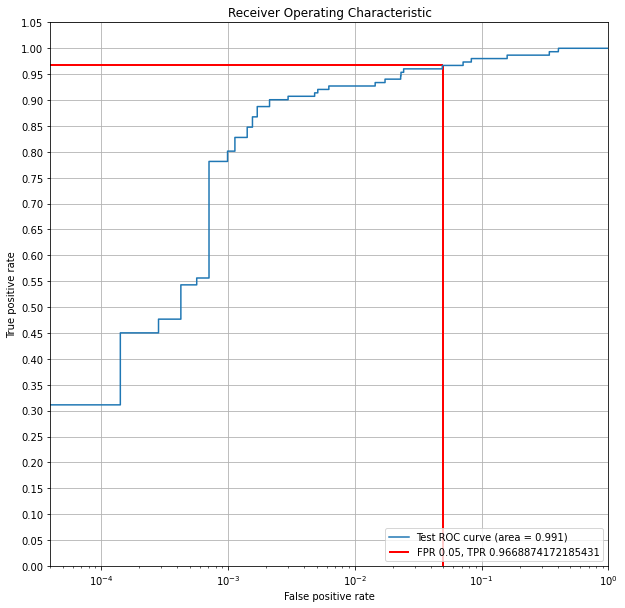

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
y_test_pred = rfc.predict_proba(x_test)[:, 1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred, drop_intermediate=False)
test_roc_auc = auc(test_fpr, test_tpr)

print(test_fpr.shape, test_tpr.shape)
# Plot ROC curve
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

ax.plot(test_fpr, test_tpr, label='Test ROC curve (area = %0.3f)' % test_roc_auc)

REQUIRED_FPR = 0.05
fpr_idx = np.argmax(test_fpr >= REQUIRED_FPR)
print(fpr_idx)
required_tpr = test_tpr[fpr_idx]

ax.vlines(REQUIRED_FPR, 0, required_tpr, color="r", lw=2)
ax.hlines(required_tpr, REQUIRED_FPR, 0, color="r", lw=2, label=f'FPR {REQUIRED_FPR}, TPR {required_tpr}')

ax.set_xlim([0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_yticks(np.arange(22) / 20.0)
ax.set_xlim([4e-5, 1.0])

ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
ax.set_xscale("log")

plt.gca().grid(True)

plt.show()

### TF/IDF

In [33]:
# Train TF/IDF model
tfidf_vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.95)
tfidf_vectorizer.fit(pan12_train_df['preprocessed_bow'])

# Transform chat messages to vocabulary vectors
vectorized_data = tfidf_vectorizer.transform(pan12_train_df['preprocessed_bow'])
print(f'Vectorized data shape: {vectorized_data.shape}')

print(pan12_train_df['preprocessed_bow'][6])
print(vectorized_data[6])


Vectorized data shape: (35922, 9975)
miss good look just get online check email then go work
  (0, 9836)	0.2393238979041618
  (0, 8832)	0.25069318497629534
  (0, 6079)	0.4695066051679182
  (0, 5534)	0.3867451164271769
  (0, 5114)	0.2578100016849032
  (0, 4750)	0.2006986385158662
  (0, 3696)	0.24595548755966867
  (0, 3679)	0.22562544720261285
  (0, 3613)	0.21351770575329246
  (0, 2805)	0.3589607744260889
  (0, 1435)	0.34246055030924777


In [34]:
# create dataframe of vectors
tfidf_df = pd.DataFrame(vectorized_data.toarray(), columns=tfidf_vectorizer.get_feature_names())
# tfidf_df[['sex', 'babe', 'young', 'age', 'dick']].sort_values('dick', ascending=False)


In [35]:
# https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html
#Visualize TF/IDF


## Backup - not useful currently

### Pan12 dataloader and dataset

#### pan12 line level dataloader

In [36]:
class Pan12LineLevelDataloader():  
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(self, chat_data_file: Path, user_labels_file: Path=None, line_labels_file: Path=None, preprocess_fn=None, preprocess_args:Dict=None):
        """
        Args:
            chat_data_file: path to chat xml file
            conversation_labels:
            line_labels:  
        """
       
        self.chat_data_file = chat_data_file
        self.conversations = self._get_conversation_roots(chat_data_file)
        self.preprocess_fn = preprocess_fn
        self.preprocess_args = preprocess_args

        self.user_labels_file = user_labels_file
        self.line_labels_file = line_labels_file
        self.TEXT_COLUMN_NAME = 'text'

        self.length = self._get_ds_length()
        self.num_conversations = len(self.conversations)

        # Initiate queue
        self.message_list = None
        self.current_conversation_id = None
        self.next_conversation_idx = 0
        self.next_message_idx = 0

        # Create sets of problematic lines and authors for labels
        user_labels = pd.read_csv(user_labels_file, delimiter='\t', header=None)
        self.perverted_authors = set(user_labels[0])

        line_labels = pd.read_csv(line_labels_file, delimiter='\t', header=None)
        line_labels['concat'] = line_labels[0] + '_' + line_labels[1].astype(str)
        self.pervert_lines = set(line_labels['concat'])

        self.load_next_conversation_to_list()
                       
    def __iter__(self):
        return self

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return self.length

    def __next__(self) -> Dict[str, pd.DataFrame]:
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """        
        message_dict = {}
        try:
            message = self.message_list[self.next_message_idx]
        except(IndexError):
            self.load_next_conversation_to_list()
            message = self.message_list[self.next_message_idx]

        message_dict['conversation_id'] = self.current_conversation_id
        self.next_message_idx += 1
        
        message_dict['line'] = message.attrib['line']  

        for field in message:
            message_dict[field.tag] = field.text
        
        if self.preprocess_fn is not None:
            message_dict['text'] = self.preprocess_fn(message_dict['text'], **self.preprocess_args)
        
        message_dict['author_label'] = 1 if message_dict['author'] in self.perverted_authors else 0
        message_dict['line_label'] = 1 if message_dict['conversation_id'] + '_' + message_dict['line'] in self.pervert_lines else 0

        return message_dict
    
    def _get_conversation_roots(self, file_path):
        doc_tree = ET.parse(file_path)
        conversation_roots = doc_tree.getroot().findall('conversation')
        return conversation_roots

    def _get_ds_length(self):
        number_messages = 0
        for conversation in self.conversations:
            number_messages += len(conversation.findall('message'))
        
        return number_messages

    def load_next_conversation_to_list(self):
        try:
            conversation = self.conversations[self.next_conversation_idx] 
            self.current_conversation_id = conversation.attrib['id']  
        except(IndexError):
            raise StopIteration()

        self.next_conversation_idx += 1
        self.message_list = [m for m in conversation.findall('message')]
        self.next_message_idx = 0

In [37]:
# # Test dataset
# preprocess_args = {'stemmer': PorterStemmer(),
#                     'speller': SpellChecker(),
#                     'words_to_remove': set(stopwords.words('english')),
#                     'emoticons': emoticons,
#                     'chat_slang': chat_slang
#                     }

# pan12_ds = Pan12LineLevelDataloader(PAN12_TEST_DATA_FILE, user_labels_file=PAN12_USER_LABELS_FILE, line_labels_file=PAN12_LINE_LABELS_FILE, preprocess_fn=preprocess_string_for_bow, preprocess_args=preprocess_args)
# print(len(pan12_ds))

# for i, m in enumerate(pan12_ds):
#     print(i, m) 
#     if i==50:
#         break

## some thoughts
Bag of words - sexual words, fear, trust, family, approach (Location, transport) , other categories - DrouinBoydHancockJames2017
Good article: file:///D:/docs/DSML_IDC/Semester%204/Cyber/Tasks/Task2/ref%20docs/Early%20Text%20Classification%20using%20Multi-Resolution%20Concept%20Representations.pdf
Ensamble and preprocessing: file:///D:/docs/DSML_IDC/Semester%204/Cyber/Tasks/Task2/ref%20docs/PredatoryConversationDetection.pdf
file:///D:/docs/DSML_IDC/Semester%204/Cyber/Tasks/Task2/ref%20docs/Analyzing_Chat_Conversations_of_Pedophil.pdf
